In [1]:
import os
import glob

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np
import rasterio
import xarray

In [2]:
# Define filepath
filepath = '/Users/morganscafidi/Documents/GitHub/geospatial-data-science/labs/lab4/data/'
# Define list of Landsat bands
files = sorted(glob.glob(filepath + 'landsat/*.tif'))
print(files)

['/Users/morganscafidi/Documents/GitHub/geospatial-data-science/labs/lab4/data/landsat/LC08_L2SP_047029_20200814_20210330_02_T1_SR_B1.tif', '/Users/morganscafidi/Documents/GitHub/geospatial-data-science/labs/lab4/data/landsat/LC08_L2SP_047029_20200814_20210330_02_T1_SR_B2.tif', '/Users/morganscafidi/Documents/GitHub/geospatial-data-science/labs/lab4/data/landsat/LC08_L2SP_047029_20200814_20210330_02_T1_SR_B3.tif', '/Users/morganscafidi/Documents/GitHub/geospatial-data-science/labs/lab4/data/landsat/LC08_L2SP_047029_20200814_20210330_02_T1_SR_B4.tif', '/Users/morganscafidi/Documents/GitHub/geospatial-data-science/labs/lab4/data/landsat/LC08_L2SP_047029_20200814_20210330_02_T1_SR_B5.tif', '/Users/morganscafidi/Documents/GitHub/geospatial-data-science/labs/lab4/data/landsat/LC08_L2SP_047029_20200814_20210330_02_T1_SR_B6.tif', '/Users/morganscafidi/Documents/GitHub/geospatial-data-science/labs/lab4/data/landsat/LC08_L2SP_047029_20200814_20210330_02_T1_SR_B7.tif', '/Users/morganscafidi/Docu

In [3]:
# Open a single band
src = rasterio.open(files[1])
band_1 = src.read(1)

In [4]:
# Find metadata (e.g. driver, data type, coordinate reference system, transform etc.)
print(src.profile)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 1208, 'height': 1422, 'count': 1, 'crs': CRS.from_epsg(32610), 'transform': Affine(30.0, 0.0, 391695.0,
       0.0, -30.0, 4880565.0), 'tiled': False, 'interleave': 'band'}


In [5]:
# Find coordinate reference system
src.crs # https://epsg.io/32610

CRS.from_epsg(32610)

In [6]:
# Find format
src.driver

'GTiff'

In [7]:
# Find pixel size
src.transform[0]

30.0

In [8]:
# Find bounds of dataset
src.bounds

BoundingBox(left=391695.0, bottom=4837905.0, right=427935.0, top=4880565.0)

In [9]:
# Get corners of dataset
full_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
print(full_extent)

[391695.0, 427935.0, 4837905.0, 4880565.0]


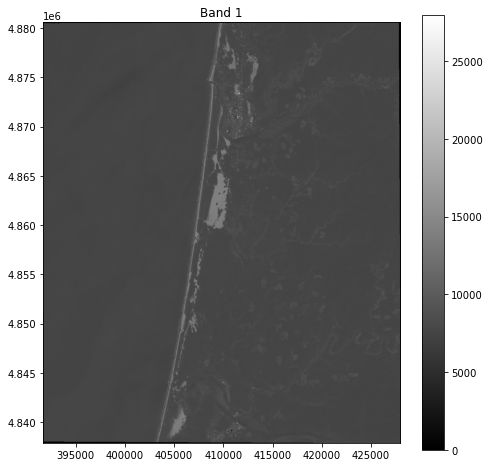

In [10]:
# Plot dataset
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(band_1, cmap='gray', extent=full_extent)
ax.set_title("Band 1")
fig.colorbar(im, orientation='vertical')
plt.show()

In [11]:
# Find number of columns and rows in array
band_1.shape

(1422, 1208)

In [12]:
# Find total number of pixels in array
band_1.size

1717776

In [13]:
# Find maximum value in array
band_1.max()

27945

In [14]:
# Find datatype
band_1.dtype

dtype('uint16')

In [15]:
# Find maximum possible value in array
2**16

65536

In [16]:
# Find file size (in MB)
band_1.nbytes / 1000000

3.435552

In [17]:
# Open all bands in a loop
list_bands = []
for file in files:
    # Read band
    src = rasterio.open(file)
    band = src.read(1)
    
    # Append to list
    list_bands.append(band)

# Convert from list of arrays to n-dimensional array
all_bands = np.dstack(list_bands)

In [18]:
all_bands.shape

(1422, 1208, 8)

In [19]:
# Convert values to a range of 0-255
all_bands_image = np.uint8((all_bands / 65536) * 255)

In [20]:
# Produce a new array by stacking the RGB bands
rgb = np.dstack((all_bands_image[:,:,3],all_bands_image[:,:,2],all_bands_image[:,:,1]))

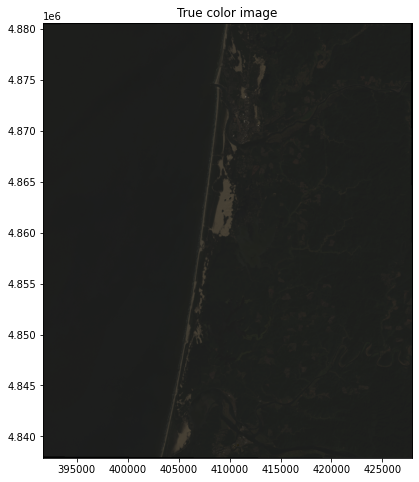

In [21]:
# Plot as RGB image
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(rgb, extent=full_extent)
ax.set_title("True color image")
plt.show()

In [22]:
# Compute NDWI
np.seterr(divide='ignore', invalid='ignore')
ndwi = np.divide((all_bands[:,:,2].astype(float) - all_bands[:,:,4].astype(float)), \
                 (all_bands[:,:,2].astype(float) + all_bands[:,:,4].astype(float)))

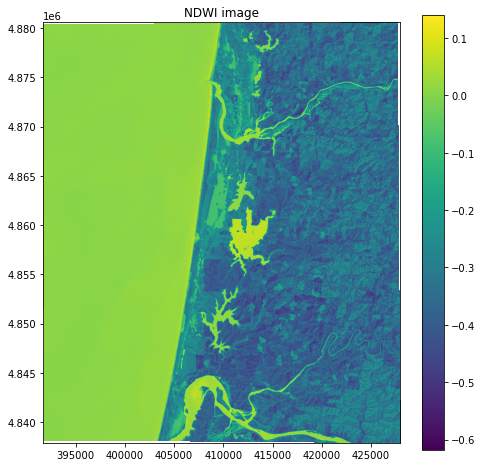

In [23]:
# Plot NDWI image
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(ndwi, extent=full_extent)
ax.set_title("NDWI image")
fig.colorbar(im, orientation='vertical')
plt.show()

In [24]:
# Write an array as a raster band to a new 8-bit file. For the new file's profile, 
# we start with the profile of the source
profile = src.profile

# And then change the band count to 3, set the dtype to uint8, and specify LZW compression.
profile.update(dtype=rasterio.uint8, count=3, compress='lzw')

In [25]:
with rasterio.open(filepath + 'landsat/rgb.tif', 'w', **profile) as dst:
    # Write array
    dst.write(np.rollaxis(rgb, axis=2)) # Note that array needs to be in bands, rows, cols order (z, y, x)

In [26]:
filepath

'/Users/morganscafidi/Documents/GitHub/geospatial-data-science/labs/lab4/data/'

In [27]:
# Read data
xds = xarray.open_dataset(filepath + 'era/usa_t2m_tcc_2020.nc', decode_coords='all')

In [30]:
# Question 3 a) an NDVI image (i.e. (Band 5 - Band 4) / (Band 5 + Band 4))
# Compute NDVI
np.seterr(divide='ignore', invalid='ignore')
ndvi = np.divide((all_bands[:,:,5].astype(float) - all_bands[:,:,4].astype(float)), \
                 (all_bands[:,:,5].astype(float) + all_bands[:,:,4].astype(float)))


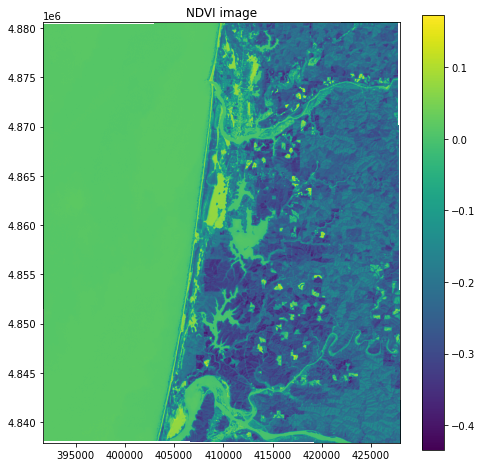

In [29]:
# Plot NDVI image
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(ndvi, extent=full_extent)
ax.set_title("NDVI image")
fig.colorbar(im, orientation='vertical')
plt.show()